### This notebook plots the model predictions on the features of an inputs file.###

In [1]:
import numpy as np
import math
import keras
import matplotlib.pyplot as plt
import keras.backend as K
import sys
sys.path.insert(0, '../utils')
from utils import *
sys.path.insert(0,'../preprocessing')
from data_config import config as d_config
sys.path.insert(0, '../train')
from model_configs import get_weighted_bce
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


In [2]:
#get file numbers
data_config = d_config()

fs = data_config.fs
num_features = data_config.num_features

print('Train files: ', data_config.train_files)
print('Val files: ', data_config.val_files)
print('Test files: ',data_config.test_files)

Train files:  [0, 1, 2, 4]
Val files:  [5]
Test files:  [3]


In [3]:
file_num = 5

features = np.load('../preprocessing/numpy_data/inputs/inputs_' + str(file_num) + '.npy')
labels = np.load('../preprocessing/numpy_data/labels/labels_' + str(file_num) + '.npy')

totalSeconds = int(len(labels))/fs

print ('Seconds of lunge data: ', totalSeconds)
print ('Hours: ', totalSeconds/3600)

Seconds of lunge data:  5000.0
Hours:  1.3888888888888888


In [4]:
#defining custom loss function
pos_weight = 1 #this setting doesn't matter here, just helps to load the model
weighted_bce = get_weighted_bce(pos_weight)
get_custom_objects().update({"weighted_bce": weighted_bce})

In [5]:
#load label model

#SET THESE: the folder and the name of the desired label model, as well as flattened_input
folder = 'feed_forward_Sat_Aug__3_11-51-22_2019'
model_name = 'ep_2_tp_0.983_fp_0.0_f_1_0.991_f_2_0.986_chain_2_thresh_0.5'
flattened_input = True #true for feed forward, false for resnet

model_name_split = model_name.split('_')
thresholds = [float(model_name_split[-1])]
chaining_dists = [float(model_name_split[-3])]
model = keras.models.load_model('../models/label_models/' + folder + '/' + model_name,
                               custom_objects={'loss': weighted_bce })

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
correction_model = None

In [ ]:
#run this cell if using correction model
def avgabs(y_true,y_pred): ##in seconds (if perturbation_max = 5*fs)
    return K.mean(K.abs(5*(y_true - y_pred)))

correction_model = keras.models.load_model('../models/correction_models/correction_model.h5', 
                                           custom_objects={'avgabs': avgabs})

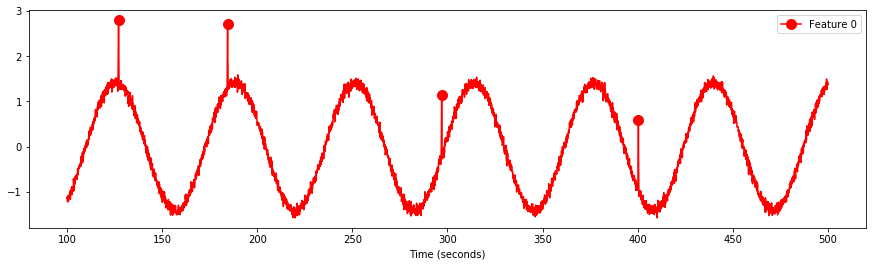

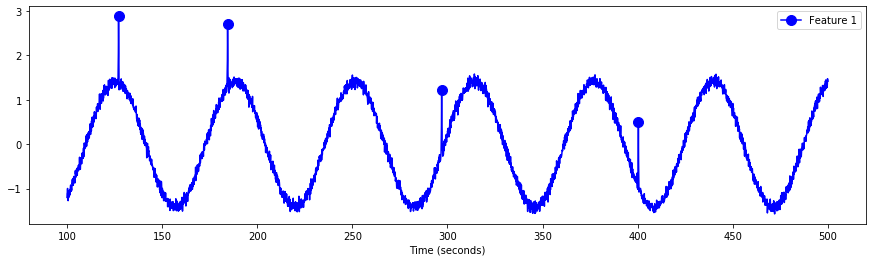

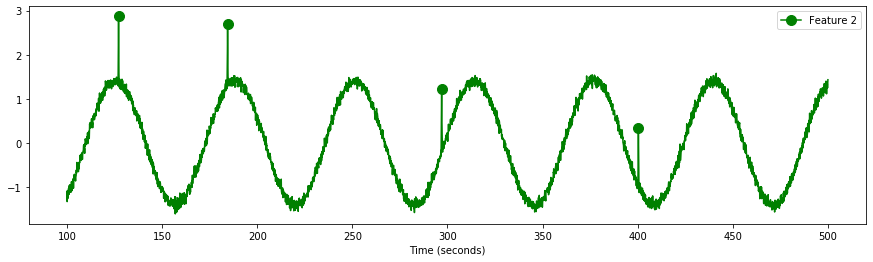

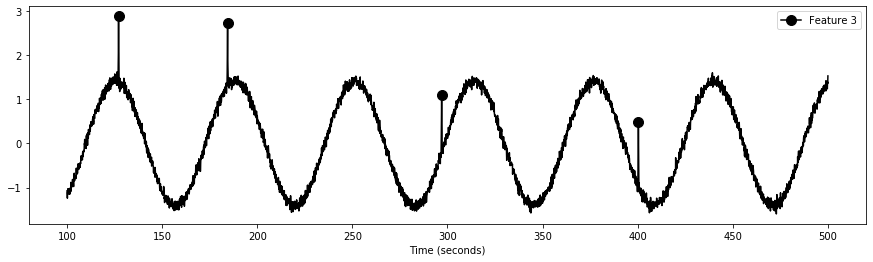

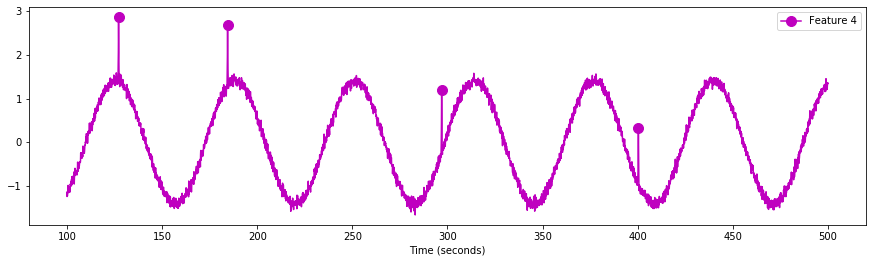

In [7]:
# Plot the features with lunge labels from startTime to endTime
startTime = 100
endTime = 500
windowTime = endTime-startTime

startSample = startTime*fs
numSamples = windowTime*fs


selected_features = features[startSample:startSample+numSamples,:]
selected_labels = labels[startSample:startSample+numSamples]

t = np.linspace(startTime,startTime+windowTime,numSamples)
tmp = np.where(selected_labels == 1)[0]
markers = [tmp[i] for i in range(len(tmp))]

plt.rcParams['lines.markersize'] = 10
h = 4 #fig width/height
w = 15
colors = ['r', 'b', 'g', 'k', 'm']

for i in range(num_features):
    plt.figure(figsize=(w, h))
    x = selected_features[:, i]
    plt.plot(t,x,marker='o', color=colors[i%len(colors)], label='Feature {}'.format(i), markevery=markers)
    plt.xlabel('Time (seconds)')
    plt.legend()
plt.show()

In [8]:
print('The lunge times are :')
print (np.where(labels == 1)[0]/fs)

The lunge times are :
[  65.1  127.1  184.4  296.9  400.3  501.4  552.3  659.6  756.1  844.7
  893.5 1016.2 1074.8 1169.7 1261.3 1379.8 1465.6 1577.1 1654.4 1779.3
 1868.4 1942.5 2018.9 2094.2 2183.4 2241.1 2322.5 2368.3 2444.9 2492.5
 2539.6 2624.1 2734.1 2865.7 3014.1 3113.7 3164.9 3257.1 3324.3 3417.7
 3488.2 3556.5 3606.1 3683.8 3747.5 3868.2 3944.3 4050.8 4176.  4278.9
 4319.  4363.1 4425.  4501.9 4638.7 4737.3 4815.8 4885.5]


In [9]:
pred_labels, __ = get_predictions(features, model, flattened_input, correction_model)
pred_labels = np.array(pred_labels)

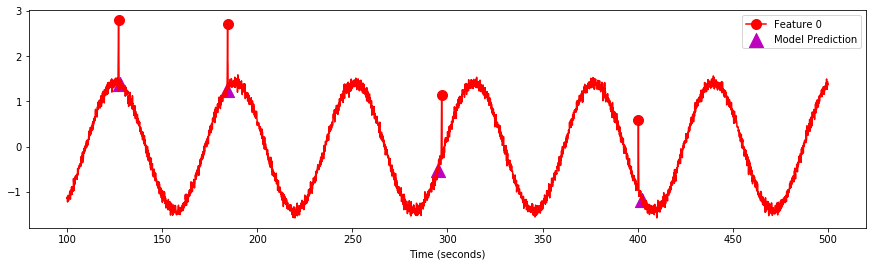

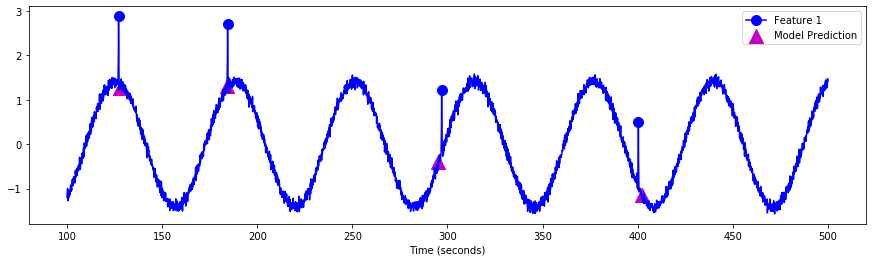

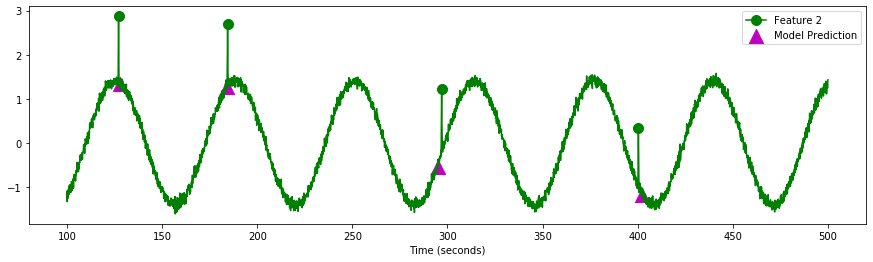

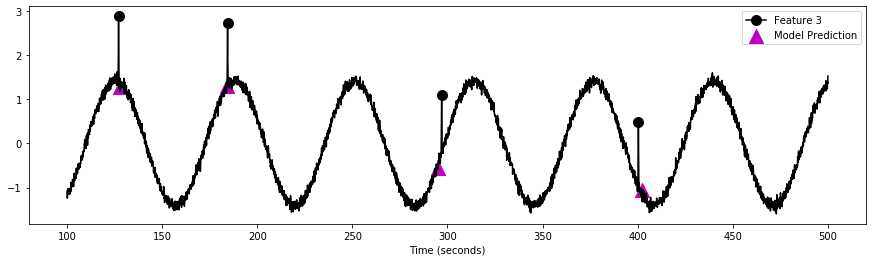

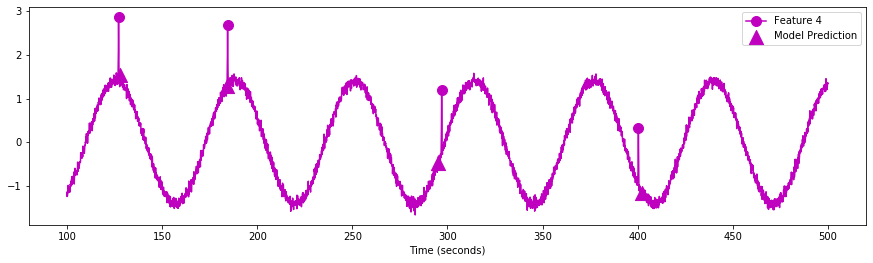

In [10]:
# Plot the features with lunge labels and model predictions from startTime to endTime
startTime = 100
endTime = 500
windowTime = endTime-startTime

startSample = startTime*fs
numSamples = windowTime*fs


selected_features = features[startSample:startSample+numSamples,:]
selected_labels = labels[startSample:startSample+numSamples]

t = np.linspace(startTime,startTime+windowTime,numSamples)

tmp = np.where(selected_labels == 1)[0]
true_label_markers = [tmp[i] for i in range(len(tmp))]
prediction_markers = [s - startSample for s in pred_labels if s>= startSample and s<startSample+numSamples]

plt.rcParams['lines.markersize'] = 10
h = 4 #fig width/height
w = 15

colors = ['r', 'b', 'g', 'k', 'm']

for i in range(num_features):
    fig = plt.figure(figsize=(w, h))
    x = selected_features[:,i]
    plt.plot(t,x,marker='o', color=colors[i%5], label='Feature {}'.format(i), markevery=true_label_markers)
    plt.scatter(t[prediction_markers],x[prediction_markers], label='Model Prediction', marker='^', color='m',s = 200)
    plt.xlabel('Time (seconds)')
    plt.legend()
plt.show()